<a href="https://colab.research.google.com/github/plaban1981/Langchain_usecases/blob/main/Retrieval_Augmented_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip  install -qU openai langchain PyPDF2 transformers tiktoken pinecone-client sentence-transformers qdrant-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.3 MB/s eta 0:00:00
 

In [2]:
import PyPDF2
from PyPDF2 import PdfReader

In [3]:
!wget "https://content.accion.org/wp-content/uploads/2018/08/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf"

--2023-07-25 06:00:43--  https://content.accion.org/wp-content/uploads/2018/08/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf
Resolving content.accion.org (content.accion.org)... 151.101.194.159
Connecting to content.accion.org (content.accion.org)|151.101.194.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 724217 (707K) [application/pdf]
Saving to: ‘Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf’

Employee-Stock-Opti 100%[===================>] 707.24K  --.-KB/s    in 0.03s   

2023-07-25 06:00:44 (23.6 MB/s) - ‘Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf’ saved [724217/724217]



In [4]:
def is_scanned_pdf(file_path):
    page_num  = []
    page_content = []
    pdf_reader = PdfReader(file_path)
    text = ""
    for i,page in enumerate(pdf_reader.pages):
      page_num.append(f"Page{i+1}")
      page_content.append(page.extract_text())
      text += page.extract_text()

    # if no text found, it is likely a scanned pdf
    if text == "":
        print("Scanned PDF")
        return True,page_num,page_content

    else:
        print("Text-based PDF")
        return False,page_num,page_content

In [ ]:
file_path = "/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf"
flag,page_num,page_content = is_scanned_pdf(file_path)

Text-based PDF


In [ ]:
len(page_num),len(page_content)

(44, 44)

In [ ]:
page_content[:5]

['Startup Employee Stock \nOptions Plans (ESOPs)  \n \nOverview and Best Practices  \n',
 'Table of Contents  \nPart I: Intro to Options Plans  \n•What is an ESOP?  \n•What is an Option?  \n•Lifecycle of a Startup ESOP  \n•Common Terms in an Options Package  \n•Why Issue Options to Employees ? \n–A Defining Characteristic of Startup Culture  \n–A Necessary Part of the Capital Structure  \n•When to Create an ESOP ? \n•Communicating Options to Employees: % versus $ \n \nPart II: How Much to Grant  \n•Two Approaches  \n•The Top -Down Process  \n–1. How Much Equity to Set Aside in the ESOP ? \n–2. A Typical Distribution Schedule  \n•The Bottom -Up Process  \n–1. Segment Your Human Resources  \n–2. Establish Pay Multipliers for Each Role \n–3. Determine the Dollar Value of the Options Grant  \n–4. Determine the Current Share Price  \n–5. Calculate the Options Grant  \n–An Example: Hiring a CTO  \n•Important Takeaways  Part III : The Fine Print – Terms  \n•Strike Price  \n•Vesting Schedule  

In [5]:
! pip install -qU sentence_transformers

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings()
doc_result = embeddings.embed_documents([page_content[1]])

In [ ]:
embeddings

HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
), model_name='sentence-transformers/all-mpnet-base-v2', cache_folder=None, model_kwargs={}, encode_kwargs={})

In [ ]:
doc_result = embeddings.embed_documents(page_content)

In [ ]:
len(doc_result)

44

In [ ]:
len(doc_result[0]),len(doc_result[1])

(768, 768)

In [ ]:
import openai
from getpass import getpass
import os
os.environ["OPENAI_API_KEY"] =getpass()

··········


## VectorDatabase

In [ ]:
index_name = 'langchain-retrieval-augmentation'

In [ ]:
os.environ["PINECONE_API_KEY"] = getpass()

··········


In [ ]:
os.environ["PINECONE_ENVIRONMENT"] = "us-west1-gcp"

In [ ]:
import pinecone

# find API key in console at app.pinecone.io
PINECONE_API_KEY = os.getenv('PINECONE_API_KEY')
# find ENV (cloud region) next to API key in console
PINECONE_ENVIRONMENT = os.getenv('PINECONE_ENVIRONMENT')

pinecone.init(
    api_key=PINECONE_API_KEY ,
    environment=PINECONE_ENVIRONMENT,
)

if index_name not in pinecone.list_indexes():
    # we create a new index
    pinecone.create_index(
        name=index_name,
        metric='cosine',
        dimension=len(doc_result[0])  # 768
    )

## Connect to Index

In [ ]:
index = pinecone.Index(index_name)

index.describe_index_stats()

{'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [ ]:
page_num[0]

'Page1'

In [ ]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

tiktoken_len(page_content[1])

310

## Populate the vector database with huggingface embedings

* We can perform the indexing task using the LangChain vector store object. But for now it is much faster to do it via the Pinecone python client directly. We will do this in batches of 10

In [ ]:
from tqdm.auto import tqdm
from uuid import uuid4
from langchain.text_splitter import RecursiveCharacterTextSplitter
batch_limit = 100

texts = []
metadatas = []
#
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=tiktoken_len,
    separators=["\n\n", "\n", " ", ""]
)

for p,record in tqdm(zip(page_num,page_content)):
    # first get metadata fields for this record
    metadata = {'page number': p}
    # now we create chunks from the record text
    record_texts = text_splitter.split_text(record)
    # create individual metadata dicts for each chunk
    record_metadatas = [{
        "chunk": j, "text": text, **metadata
    } for j, text in enumerate(record_texts)]
    # append these to current batches
    texts.extend(record_texts)
    metadatas.extend(record_metadatas)
    # if we have reached the batch_limit we can add texts
    if len(texts) >= batch_limit:
        ids = [str(uuid4()) for _ in range(len(texts))]
        embeds = embeddings.embed_documents(texts)
        index.upsert(vectors=zip(ids, embeds, metadatas))
        texts = []
        metadatas = []

if len(texts) > 0:
    ids = [str(uuid4()) for _ in range(len(texts))]
    embeds = embeddings.embed_documents(texts)
    index.upsert(vectors=zip(ids, embeds, metadatas))

0it [00:00, ?it/s]

In [ ]:
index.describe_index_stats()

{'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 44}},
 'total_vector_count': 44}

In [ ]:
query = "What is an ESOP?"
xq = embeddings.embed_documents([query])
response = index.query(xq,top_k=1, include_metadata=True)
print(response['matches'][0]['metadata']['page number'])
print(response['matches'][0]['metadata']['text'])

Page4
What is an ESOP?  
•An Employee Stock Options Plan (ESOP)  
 
•An allocation  of shares that will be granted to employees in the future 
in the form of stock options  
–How much equity should we set aside for employees?  
 
•A plan for how these options will be distributed:  
–How many shares will individual employees receive?  
–What terms will govern these grants?  
 
•The plan is as important as the allocation!


In [ ]:
print(response['matches'][1]['metadata']['page number'])
print(response['matches'][1]['metadata']['text'])

Page14
Two Approaches  
In reality, creating an ESOP will require a combination of 
top-down and bottom -up planning  Top Down  Bottom Up  
Decide the total amount of 
equity to be granted; allocate 
these shares to employees 
over time  Decide the appropriate size of 
individual equity grants by 
position; issue these shares as 
employees are hired


In [ ]:
print(response['matches'][2]['metadata']['page number'])
print(response['matches'][2]['metadata']['text'])

Page35
ESOPS FOR THE LONG TERM  Part IV


In [ ]:
response

{'matches': [{'id': '2486fbd3-1ab1-4d00-8be9-6c71679c46cc',
              'metadata': {'chunk': 0.0,
                           'page number': 'Page4',
                           'text': 'What is an ESOP?  \n'
                                   '•An Employee Stock Options Plan (ESOP)  \n'
                                   ' \n'
                                   '•An allocation  of shares that will be '
                                   'granted to employees in the future \n'
                                   'in the form of stock options  \n'
                                   '–How much equity should we set aside for '
                                   'employees?  \n'
                                   ' \n'
                                   '•A plan for how these options will be '
                                   'distributed:  \n'
                                   '–How many shares will individual employees '
                                   'receive?  \n'
              

## Generative Question-Answering
In GQA we take the query as a question that is to be answered by a LLM, but the LLM must answer the question based on the information it is seeing being returned from the vectorstore.

To do this we initialize a RetrievalQA object like so:

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.chains import RetrievalQAWithSourcesChain

In [ ]:
# completion llm
llm = ChatOpenAI(
    openai_api_key=os.environ["OPENAI_API_KEY"],
    model_name='gpt-3.5-turbo',
    temperature=0.0
)

In [ ]:
from langchain.vectorstores import Pinecone

text_field = "text"

# switch back to normal index for langchain
index = pinecone.Index(index_name)

vectorstore = Pinecone(
    index, embeddings.embed_query, text_field
)

In [ ]:
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever(),
)

In [ ]:
qa(query)

{'query': 'What is an ESOP?',
 'result': 'An ESOP, or Employee Stock Options Plan, is a program that allows employees to receive shares of company stock in the form of stock options. It involves allocating a certain amount of equity to be granted to employees in the future. The plan also includes determining how many shares each employee will receive and the terms that will govern these grants. It is important to seek legal advice from an experienced startup lawyer when structuring an ESOP.'}

In [ ]:
qa_with_sources = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever()
)

In [ ]:
qa_with_sources(query)

ValueError: ignored

## Langchain with Qdrant

## Qdrant Metadata
Qdrant stores your vector embeddings along with the optional JSON-like payload. Payloads are optional, but since LangChain assumes the embeddings are generated from the documents, we keep the context data, so you can extract the original texts as well.

By default, your document is going to be stored in the following payload structure:
```
{
    "page_content": "Lorem ipsum dolor sit amet",
    "metadata": {
        "foo": "bar"
    }
}
```

In [ ]:
from qdrant_client import models, QdrantClient

## Define storage location

In [ ]:
qdrant = QdrantClient(":memory:")

## Create a collection

In [ ]:
qdrant.recreate_collection(
	collection_name="langchain-retrieval-augmentation",
	vectors_config=models.VectorParams(
		size=len(doc_result[0]), # Vector size is defined by used model
		distance=models.Distance.COSINE
	)
)

True

In [ ]:
type(doc_result)

list

In [ ]:
index_name = 'langchain-retrieval-augmentation'

In [ ]:
from tqdm.auto import tqdm
from uuid import uuid4
from langchain.text_splitter import RecursiveCharacterTextSplitter
batch_limit = 10

texts = []
metadatas = []
#
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    separators=["\n\n", "\n", " ", ""]
)

for p,record in tqdm(zip(page_num,page_content)):
    # first get metadata fields for this record
    metadata = {'page number': p}
    # now we create chunks from the record text
    record_texts = text_splitter.split_text(record)
    # create individual metadata dicts for each chunk
    record_metadatas = [{
        "chunk": j, "text": text, **metadata
    } for j, text in enumerate(record_texts)]
    # append these to current batches
    texts.extend(record_texts)
    metadatas.extend(record_metadatas)
    # if we have reached the batch_limit we can add texts
    if len(texts) >= batch_limit:
        ids = [str(uuid4()) for _ in range(len(texts))]
        embeds = embeddings.embed_documents(texts)
        qdrant.upsert(
        collection_name=index_name,
        points=models.Batch(ids=ids, vectors=embeds, payloads=metadatas),
        )
        texts = []
        metadatas = []

if len(texts) > 0:
    ids = [str(uuid4()) for _ in range(len(texts))]
    embeds = embeddings.embed_documents(texts)
    qdrant.upsert(
        collection_name=index_name,
        points=models.Batch(ids=ids, vectors=embeds, payloads=metadatas),
        )

0it [00:00, ?it/s]

In [ ]:
query = "What are the Common Terms in an Options Package?"
xq = embeddings.embed_documents([query])

In [ ]:
type(xq)

list

In [ ]:
collections = qdrant.get_collections()
print(collections)

collections=[CollectionDescription(name='langchain-retrieval-augmentation')]


In [ ]:
collection_vector_count = qdrant.get_collection(collection_name=index_name).vectors_count
print(f"Vector count in collection: {collection_vector_count}")

Vector count in collection: 50


In [ ]:
type(xq)

list

In [ ]:
def get_match(query_embed):
  result = qdrant.search(
            collection_name=index_name,
            query_vector=query_embed[0],
            limit=1,
            with_vectors=True,
            with_payload=True,
        )
  #print(result)
  context = [[x.payload["text"], x.payload["page number"]] for x in result]
  #print(context)
  response = {"text":context[0][0],"page_number":context[0][1]}
  return response

## Query1

In [ ]:
query = "What are the Common Terms in an Options Package?'"
xq = embeddings.embed_documents([query])
get_match(xq)

{'text': 'Common Terms in an Options Package  \nNumber of Shares  The total number of  options granted to an \nemployee, and therefore the maximum number of \nshares that employee has access to   \nStrike Price  The price the  employee must pay to purchase \neach share if and when the employee chooses to \nexercise the option  \nVesting  Schedule  The timeline over which the options become \nwholly owned and exercisable  by the employee \n(no longer subject to repurchase by the company)  \nCliff Period  The trial  period during which no vesting occurs; in \nthis period vesting accrues, but the total effect of \nthis vesting is realized immediately after the cliff  \nExpiration Date  The last date on which the options  may be \nexercised and converted into common shares by \nthe employee  \nWe will discuss the mechanics in further detail, but these basic \nterms are helpful to understanding options grants',
 'page_number': 'Page7'}

## query = 2

In [ ]:
query = "How do startups use options?"
xq = embeddings.embed_documents([query])
get_match(xq)

{'text': 'What is an Option?  \n•Why do options have intrinsic value?  \n–A effective form of equity ownership  \n–A locked -in price for shares  \n•How do startups use options?  \n–To bring in founding team members \nwho are not co -founders  \n–To recruit, compensate and retain \nearly employees  \n–To allow later employees to share in \nthe company’s long -term upside  Terminology:   \nThis presentation uses “options” \ngenerally to refer to several types of \nsecurities that are often issued to startup \nemployees to provide for effective equity \nownership, including:  \n-Stock options (the right to buy \ncommon stock a set strike price)  \n-Restricted stock (common stock \nissued early on to top employees)  \n-Restricted stock units (a promise to \nissue common stock in the future)  \nAppropriate use of these securities will \nvary based on local regulatory and tax \nconsiderations.  An option is a right (but not an obligation) to purchase a quantity',
 'page_number': 'Page5'}

In [ ]:
query = "What is an options?"
xq = embeddings.embed_documents([query])
get_match(xq)

{'text': 'Appropriate use of these securities will \nvary based on local regulatory and tax \nconsiderations.  An option is a right (but not an obligation) to purchase a quantity \nof a company’s stock at a set price for a certain period of time',
 'page_number': 'Page5'}

## Final Inference Script

In [ ]:
os.mkdir("db")

In [ ]:
!pip install -qU transformers

In [ ]:
from qdrant_client import models, QdrantClient
from langchain.embeddings import HuggingFaceEmbeddings
import PyPDF2
from PyPDF2 import PdfReader
from tqdm.auto import tqdm
from uuid import uuid4
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from time import time,sleep
#
import os
import json

#
def is_scanned_pdf(file_path):
    page_num  = []
    page_content = []
    pdf_reader = PdfReader(file_path)
    text = ""
    for i,page in enumerate(pdf_reader.pages):
      page_num.append(f"Page{i+1}")
      page_content.append(page.extract_text())
      text += page.extract_text()

    # if no text found, it is likely a scanned pdf
    if text == "":
        print("Scanned PDF")
        return True,page_num,page_content

    else:
        print("Text-based PDF")
        return False,page_num,page_content
#
def Upsert_collection(qdrant,page_num,page_content,index_name):
    texts = []
    metadatas = []
    for p,record in tqdm(zip(page_num,page_content)):
      # first get metadata fields for this record
      metadata = {'page number': p}
      # now we create chunks from the record text
      record_texts = get_text_chunks(record)
      # create individual metadata dicts for each chunk
      record_metadatas = [{
          "chunk": j, "text": text, **metadata
      } for j, text in enumerate(record_texts)]
      # append these to current batches
      texts.extend(record_texts)
      metadatas.extend(record_metadatas)

      if len(texts) >= batch_limit:
          print(texts)
          print(metadatas)
          #
          ids = [str(uuid4()) for _ in range(len(texts))]
          embeds = embeddings.embed_documents(texts)

          qdrant.upsert(
          collection_name=index_name,
          points=models.Batch(ids=ids, vectors=embeds, payloads=metadatas),
          )
          texts = []
          metadatas = []

    if len(texts) > 0:
        ids = [str(uuid4()) for _ in range(len(texts))]
        embeds = embeddings.embed_documents(texts)
        qdrant.upsert(
            collection_name=index_name,
            points=models.Batch(ids=ids, vectors=embeds, payloads=metadatas),
            )
    collection_vector_count = qdrant.get_collection(collection_name=index_name).vectors_count
    print(f"Vector count in collection: {collection_vector_count}")

#

#
def get_text_chunks(text):
    text_splitter = RecursiveCharacterTextSplitter(
                            chunk_size=1000,
                            chunk_overlap=200,
                            separators=["\n\n", "\n", " ", ""]
                            )
    chunks = text_splitter.split_text(text)
    return chunks
#
def preprocess_function(request_data,content_type=None):
  pdf_docs = request_data["pdf1"]
  prompt = request_data["query"]
  flag,page_num,page_content = is_scanned_pdf(pdf_docs)
  pdf_name = "temppdf"
  f_path = os.path.join("/tmp", pdf_name)
  qdrant = QdrantClient(path ="/content/db")
  collection_name = 'DOC_Search'
  collections = qdrant.get_collections()
  print(collections)
  doc_embed = embeddings.embed_documents(page_content[0])
  print(len(doc_embed[0]))
  # only create collection if it doesn't exist
  if collection_name not in collections:
        qdrant.recreate_collection(
            collection_name=collection_name,
            vectors_config=models.VectorParams(
                size=len(doc_embed[0]),
                distance=models.Distance.COSINE,
            ),
        )
  collections = qdrant.get_collections()
  print(collections)
  return (flag,page_num,page_content,prompt)
#
def model_load_function(content):
  flag,page_num,page_content,prompt = content
  embeddings = HuggingFaceEmbeddings()
  return embeddings
#
def predict_function(context,model, content_type=None):
    embeddings = model
    flag,page_num,page_content,prompt = context
    print(len(page_num),len(page_content))
    print(prompt)
    qdrant = QdrantClient(path ="/content/db")
    collection_name = "DOC_Search"
    collections = qdrant.get_collections()
    print(collections)
    # insert records into vectorstore
    Upsert_collection(qdrant,page_num,page_content,collection_name)
    #
    collection_vector_count = qdrant.get_collection(collection_name=collection_name).vectors_count
    print(f"Vector count in collection: {collection_vector_count}")
    # Get Similar records
    query_embed = embeddings.embed_documents([prompt])
    print(query_embed)
    result = qdrant.search(
            collection_name=collection_name,
            query_vector=query_embed[0],
            limit=3,
            with_payload=True,
            search_params=models.SearchParams(
        hnsw_ef=128,
        exact=False
    ),
        )
    print(result)
    context = [[x.payload["text"], x.payload["page number"]] for x in result]
    print(context)
    t = []
    pg = []
    s = []
    for items in context:
      print(items)

    response = {"text":context[0][0],"page_number":context[0][1]}
    #
    qdrant.delete_collection(collection_name="Doc_Search")
    return response
#
def postprocess_function(predictions, content_type=None):
  return json.dumps({"response": predictions})






In [ ]:
request_data = {"pdf1":"/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf",
                "query":"What are the Common Terms in an Options Package?"}
content = preprocess_function(request_data,content_type=None)

Text-based PDF
collections=[CollectionDescription(name='DOC_Search')]
768
collections=[CollectionDescription(name='DOC_Search')]


In [ ]:
model_load_function(content)

HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
), model_name='sentence-transformers/all-mpnet-base-v2', cache_folder=None, model_kwargs={}, encode_kwargs={})

In [ ]:
model = model_load_function(content)


In [ ]:
response = predict_function(content,model, content_type=None)

44 44
What is an ESOP?
collections=[CollectionDescription(name='DOC_Search')]


0it [00:00, ?it/s]

['Startup Employee Stock \nOptions Plans (ESOPs)  \n \nOverview and Best Practices', 'Table of Contents  \nPart I: Intro to Options Plans  \n•What is an ESOP?  \n•What is an Option?  \n•Lifecycle of a Startup ESOP  \n•Common Terms in an Options Package  \n•Why Issue Options to Employees ? \n–A Defining Characteristic of Startup Culture  \n–A Necessary Part of the Capital Structure  \n•When to Create an ESOP ? \n•Communicating Options to Employees: % versus $ \n \nPart II: How Much to Grant  \n•Two Approaches  \n•The Top -Down Process  \n–1. How Much Equity to Set Aside in the ESOP ? \n–2. A Typical Distribution Schedule  \n•The Bottom -Up Process  \n–1. Segment Your Human Resources  \n–2. Establish Pay Multipliers for Each Role \n–3. Determine the Dollar Value of the Options Grant  \n–4. Determine the Current Share Price  \n–5. Calculate the Options Grant  \n–An Example: Hiring a CTO  \n•Important Takeaways  Part III : The Fine Print – Terms  \n•Strike Price  \n•Vesting Schedule  \n•Th

In [ ]:
response = predict_function(content,model, content_type=None)

44 44
What are the Common Terms in an Options Package?
collections=[CollectionDescription(name='DOC_Search')]


0it [00:00, ?it/s]

['Startup Employee Stock \nOptions Plans (ESOPs)  \n \nOverview and Best Practices', 'Table of Contents  \nPart I: Intro to Options Plans  \n•What is an ESOP?  \n•What is an Option?  \n•Lifecycle of a Startup ESOP  \n•Common Terms in an Options Package  \n•Why Issue Options to Employees ? \n–A Defining Characteristic of Startup Culture  \n–A Necessary Part of the Capital Structure  \n•When to Create an ESOP ? \n•Communicating Options to Employees: % versus $ \n \nPart II: How Much to Grant  \n•Two Approaches  \n•The Top -Down Process  \n–1. How Much Equity to Set Aside in the ESOP ? \n–2. A Typical Distribution Schedule  \n•The Bottom -Up Process  \n–1. Segment Your Human Resources  \n–2. Establish Pay Multipliers for Each Role \n–3. Determine the Dollar Value of the Options Grant  \n–4. Determine the Current Share Price  \n–5. Calculate the Options Grant  \n–An Example: Hiring a CTO  \n•Important Takeaways  Part III : The Fine Print – Terms  \n•Strike Price  \n•Vesting Schedule  \n•Th

In [ ]:
postprocess_function(response, content_type=None)

'{"response": {"text": "Common Terms in an Options Package  \\nNumber of Shares  The total number of  options granted to an \\nemployee, and therefore the maximum number of \\nshares that employee has access to   \\nStrike Price  The price the  employee must pay to purchase \\neach share if and when the employee chooses to \\nexercise the option  \\nVesting  Schedule  The timeline over which the options become \\nwholly owned and exercisable  by the employee \\n(no longer subject to repurchase by the company)  \\nCliff Period  The trial  period during which no vesting occurs; in \\nthis period vesting accrues, but the total effect of \\nthis vesting is realized immediately after the cliff  \\nExpiration Date  The last date on which the options  may be \\nexercised and converted into common shares by \\nthe employee  \\nWe will discuss the mechanics in further detail, but these basic \\nterms are helpful to understanding options grants", "page_number": "Page7"}}'

In [ ]:
qdrant.delete_collection(collection_name="Doc_Search")

True

## Using Langchain + Qdrant for Question Answering.

In [7]:
from langchain import VectorDBQA
from getpass import getpass
from langchain.embeddings import HuggingFaceEmbeddings
import os
os.environ["OPENAI_API_KEY"] = getpass()

··········


In [8]:
embeddings = HuggingFaceEmbeddings()

In [ ]:
metadatas = []
for p,record in tqdm(zip(page_num,page_content)):
      # first get metadata fields for this record
      metadata = {'page number': p}
      # now we create chunks from the record text
      record_texts = get_text_chunks(record)
      # create individual metadata dicts for each chunk
      record_metadatas = [{
          "chunk": j, "text": text, **metadata
      } for j, text in enumerate(record_texts)]
      # append these to current batches
      texts.extend(record_texts)
      metadatas.extend(record_metadatas)

0it [00:00, ?it/s]

## Qdrant Vectorstore - Cloud

In [9]:
from langchain.vectorstores.qdrant import Qdrant
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(openai_api_key=os.environ["OPENAI_API_KEY"],temperature=0)

In [ ]:

doc_store = Qdrant.from_texts(page_content,
                              metadatas=metadatas,
                              embedding=embeddings,
                              api_key="crjy1brG_LtCyAMKBsK8ni2bLIZl_NPfo9fB7x6vInwYRnsTtXmr0A",
                              url="https://f2d7092d-7da3-4b40-a8bf-41caebc0558f.us-east-1-0.aws.cloud.qdrant.io:6333")

In [10]:
from langchain.llms import OpenAI
llm = OpenAI(openai_api_key=os.environ["OPENAI_API_KEY"],temperature=0)

In [ ]:
llm = ChatOpenAI(openai_api_key=os.environ["OPENAI_API_KEY"],temperature=0)

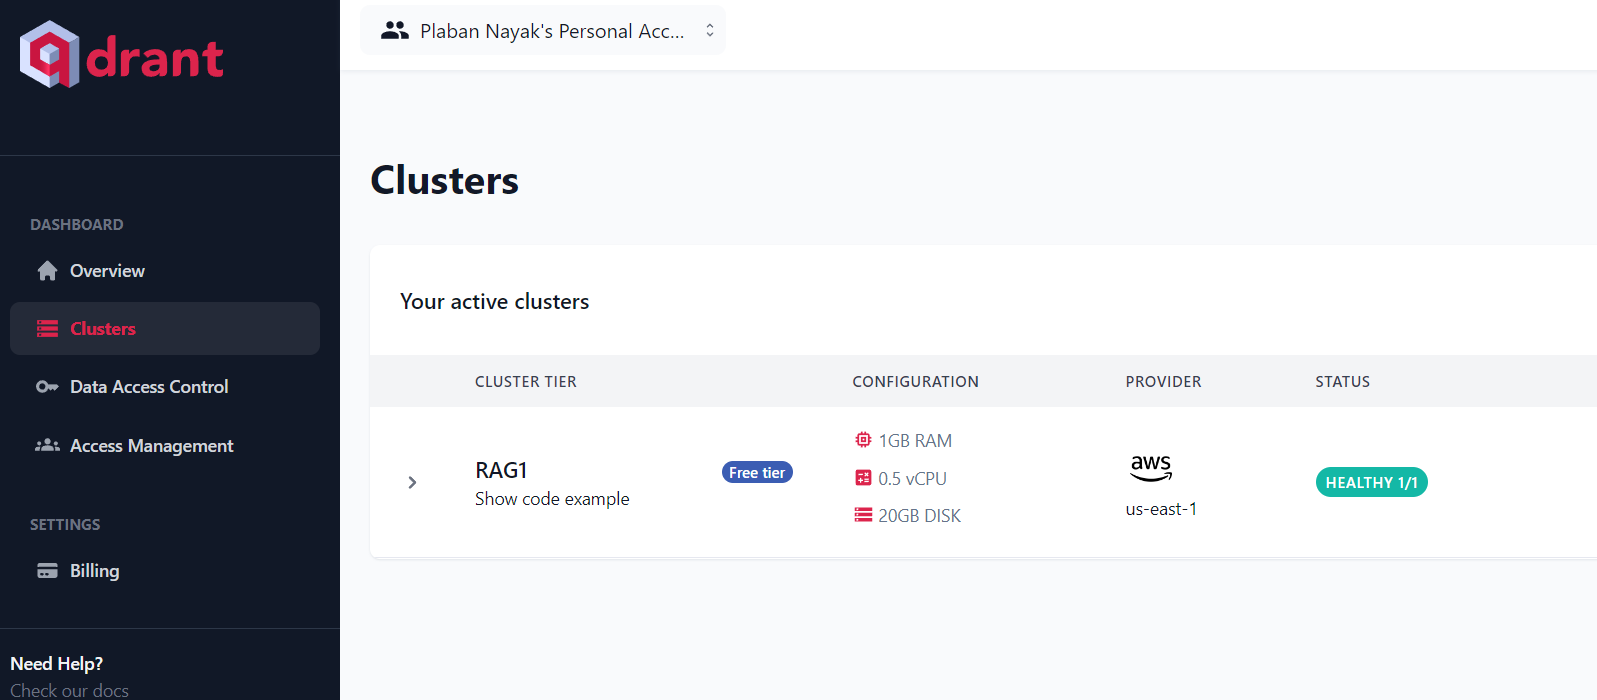

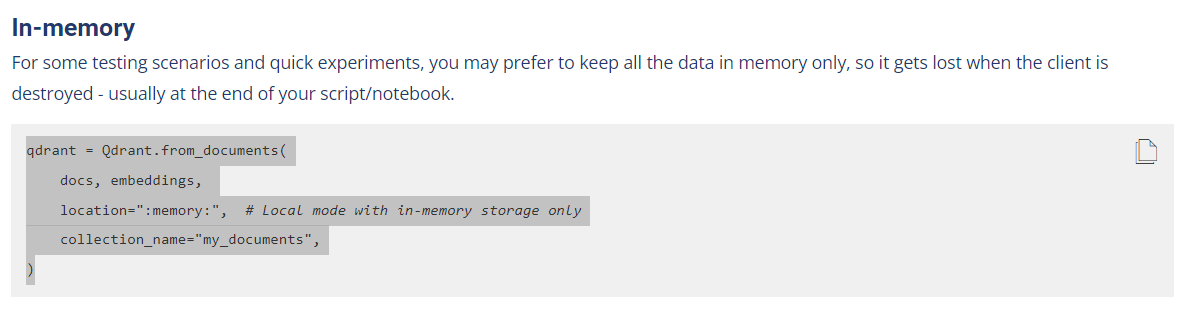

In [15]:
from tqdm import tqdm
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [18]:
#
def get_text_chunks(text):
    text_splitter = RecursiveCharacterTextSplitter(
                            chunk_size=1000,
                            chunk_overlap=200,
                            separators=["\n\n", "\n", " ", ""]
                            )
    chunks = text_splitter.split_text(text)
    return chunks
#
def preprocess_function(request_data,content_type=None):
  pdf_docs = request_data["pdf1"]
  prompt = request_data["query"]
  flag,page_num,page_content = is_scanned_pdf(pdf_docs)
  pdf_name = "temppdf"
  f_path = os.path.join("/tmp", pdf_name)
  #
  metadatas = []
  texts = []
  for p,record in tqdm(zip(page_num,page_content)):
        # first get metadata fields for this record
        metadata = {'page number': p}
        # now we create chunks from the record text
        record_texts = get_text_chunks(record)
        # create individual metadata dicts for each chunk
        record_metadatas = [{
            "chunk": j, "text": text, **metadata
        } for j, text in enumerate(record_texts)]
        # append these to current batches
        texts.extend(record_texts)
        metadatas.extend(record_metadatas)
  return (flag,page_num,page_content,metadatas,prompt)

In [19]:
request_data = {"pdf1":"/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf",
                "query":"what did fred wilson say about capital structure?"}
content = preprocess_function(request_data,content_type=None)

Text-based PDF


44it [00:00, 3511.41it/s]


In [20]:
flag,page_num,page_content,metadatas,prompt = content

In [21]:
doc_store = Qdrant.from_texts(page_content,
                              metadatas=metadatas,
                              embedding=embeddings,
                              location=":memory:",
                              collection="doc_search")

In [22]:
qa = VectorDBQA.from_chain_type(llm=llm,
                                chain_type="stuff",
                                vectorstore=doc_store,
                                return_source_documents=True)

/usr/local/lib/python3.10/dist-packages/langchain/chains/retrieval_qa/base.py:245: UserWarning: `VectorDBQA` is deprecated - please use `from langchain.chains import RetrievalQA`
  warnings.warn(


In [23]:
result = qa(prompt)

In [24]:
result

{'query': 'what did fred wilson say about capital structure?',
 'result': ' Fred Wilson said that establishing a stock option pool is a prerequisite to closing a deal for venture capitalists.',
 'source_documents': [Document(page_content='Resources & Further Reading  \n•Fred Wilson / Union Square Ventures Series on Employee Equity  \n–What are options?  \n–Structures and allocations  \n–How many options to issue?  \n–Vesting, cliffs, and change of control  \n–Trends in increasing issuance size  \n–Dilution  \n–Video: Class on Employee Equity  ', metadata={'chunk': 0, 'text': 'Discretionary Grants  \n•Bonuses Outstanding Performance  \n–These discretionary grants should only be made once per year, and \nonly offered to your top 10 -20% of employees whose \naccomplishments and performance are truly distinguished  \n•Promotions  \n–These discretionary grants should only be made to reward \npromotion. Bring the employee’s total equity up to the amount you \nwould pay to hire them today.', 

In [25]:
len(result["source_documents"])

4

In [29]:
print(f"Query : {result['query']}")
print(f"Answer : {result['result']}")
referrences = []
pages = []
for i in range(len(result["source_documents"])):
  print(f"Content : {result['source_documents'][i].page_content}")
  referrences.append(result['source_documents'][i].page_content)
  print(f"Page Number : {result['source_documents'][i].metadata['page number']}")
  pages.append(result['source_documents'][i].metadata['page number'])

Query : what did fred wilson say about capital structure?
Answer :  Fred Wilson said that establishing a stock option pool is a prerequisite to closing a deal for venture capitalists.
Content : Resources & Further Reading  
•Fred Wilson / Union Square Ventures Series on Employee Equity  
–What are options?  
–Structures and allocations  
–How many options to issue?  
–Vesting, cliffs, and change of control  
–Trends in increasing issuance size  
–Dilution  
–Video: Class on Employee Equity  
Page Number : Page37
Content : A Necessary Part of the Capital Structure  
•Venture capitalists require ESOPs . For many VCs, establishing a 
stock option pool is a prerequisite to closing a deal  
–In an industry where options are ubiquitous, startups are compelled 
to offer options packages to compete for top talent with other 
venture -backed companies  
–When operating budgets are tight, competitive compensation 
packages may not be possible; options can be used to incentivize 
employees instea

## Query 2

In [30]:
result = qa("What are the Common Terms in an Options Package?")

In [31]:
print(f"Query : {result['query']}")
print(f"Answer : {result['result']}")
referrences = []
pages = []
for i in range(len(result["source_documents"])):
  print(f"Content : {result['source_documents'][i].page_content}")
  referrences.append(result['source_documents'][i].page_content)
  print(f"Page Number : {result['source_documents'][i].metadata['page number']}")
  pages.append(result['source_documents'][i].metadata['page number'])

Query : What are the Common Terms in an Options Package?
Answer :  Number of Shares, Strike Price, Vesting Schedule, Cliff Period, Expiration Date.
Content : Common Terms in an Options Package  
Number of Shares  The total number of  options granted to an 
employee, and therefore the maximum number of 
shares that employee has access to   
Strike Price  The price the  employee must pay to purchase 
each share if and when the employee chooses to 
exercise the option  
Vesting  Schedule  The timeline over which the options become 
wholly owned and exercisable  by the employee 
(no longer subject to repurchase by the company)  
Cliff Period  The trial  period during which no vesting occurs; in 
this period vesting accrues, but the total effect of 
this vesting is realized immediately after the cliff  
Expiration Date  The last date on which the options  may be 
exercised and converted into common shares by 
the employee  
We will discuss the mechanics in further detail, but these basic 
t

In [ ]:
result['query']

'What are the Common Terms in an Options Package?'

In [ ]:
result['result']

'The common terms in an options package include the number of shares, strike price, vesting schedule, cliff period, and expiration date.'

In [ ]:
type(result["source_documents"][0])

langchain.schema.document.Document

In [ ]:
print(result["source_documents"][0].page_content)

Common Terms in an Options Package  
Number of Shares  The total number of  options granted to an 
employee, and therefore the maximum number of 
shares that employee has access to   
Strike Price  The price the  employee must pay to purchase 
each share if and when the employee chooses to 
exercise the option  
Vesting  Schedule  The timeline over which the options become 
wholly owned and exercisable  by the employee 
(no longer subject to repurchase by the company)  
Cliff Period  The trial  period during which no vesting occurs; in 
this period vesting accrues, but the total effect of 
this vesting is realized immediately after the cliff  
Expiration Date  The last date on which the options  may be 
exercised and converted into common shares by 
the employee  
We will discuss the mechanics in further detail, but these basic 
terms are helpful to understanding options grants  


In [ ]:
result["source_documents"][0].metadata['page number']

'Page5'

In [ ]:
final_output = {"Question":result['query'],
                "Answer":result['result'],
                "Page Number":result["source_documents"][0].metadata['page number'],
                "Page Content":result["source_documents"][0].page_content
}

In [ ]:
final_output

{'Question': 'What are the Common Terms in an Options Package?',
 'Answer': 'The common terms in an options package include the number of shares, strike price, vesting schedule, cliff period, and expiration date.',
 'Page Number': 'Page5',
 'Page Content': 'Common Terms in an Options Package  \nNumber of Shares  The total number of  options granted to an \nemployee, and therefore the maximum number of \nshares that employee has access to   \nStrike Price  The price the  employee must pay to purchase \neach share if and when the employee chooses to \nexercise the option  \nVesting  Schedule  The timeline over which the options become \nwholly owned and exercisable  by the employee \n(no longer subject to repurchase by the company)  \nCliff Period  The trial  period during which no vesting occurs; in \nthis period vesting accrues, but the total effect of \nthis vesting is realized immediately after the cliff  \nExpiration Date  The last date on which the options  may be \nexercised and c

In [ ]:
result = qa("When to Create an ESOP?")
final_output = {"Question":result['query'],
                "Answer":result['result'],
                "Page Number":result["source_documents"][0].metadata['page number'],
                "Page Content":result["source_documents"][0].page_content
}

In [ ]:
final_output

{'Question': 'When to Create an ESOP?',
 'Answer': 'An ESOP (Employee Stock Ownership Plan) should be created sometime between the pre-seed and early-VC stage of a startup. This is when the company is starting to gain traction and outside financing is being sought. Institutional investors will typically require an ESOP to be in place, and new hires will be seeking large equity grants. It is important to have a standardized ESOP and guidelines for the size of new-hire options grants.',
 'Page Number': 'Page9',
 'Page Content': 'When to Create an ESOP?  \nStage  Considerations  Takeaway  \nPre-seed  Founders focused on traction  (often too \nbusy for an ESOP).  Key employees are \ngiven equity/options on an ad hoc basis  ESOP  not necessary, but it can be \nhelpful to sanity check how much equity \nyou are giving away to early hires  \nSeed  First outside financing round. Investors \neither angel or institutional; institutional \ninvestors will require an ESOP  Seed rounds can be closed 

In [ ]:
prompt = "When to Communicate Options to Employees: % versus $"
result = qa(prompt)
final_output = {"Question":result['query'],
                "Answer":result['result'],
                "Page Number":result["source_documents"][0].metadata['page number'],
                "Page Content":result["source_documents"][0].page_content
}
final_output

{'Question': 'When to Communicate Options to Employees: % versus $',
 'Answer': 'Options can be communicated to employees either as a percentage of ownership in the company or as a dollar value based on the current valuation. It is recommended to communicate options grants as a dollar value when possible. However, at an early stage when there is no true valuation of the company, it may be necessary to communicate options grants as a percentage. Once the valuation is established, communicating the options grant as a dollar value is a highly effective way to communicate the true value of the grant.',
 'Page Number': 'Page10',
 'Page Content': 'Communicating Options to Employees: % versus $  \nOptions packages can be communicated either as (1) a percentage \nof ownership in the company, or (2) a dollar value based on the \ncurrent valuation; we encourage the latter when possible  \n% $ \n“We are granting you options equivalent to \n0.5% of the company’s equity”  \nConsiderations:  \n•At a

In [ ]:
prompt ="What are the approaches to grant ESOP?"
result = qa(prompt)
final_output = {"Question":result['query'],
                "Answer":result['result'],
                "Page Number":result["source_documents"][0].metadata['page number'],
                "Page Content":result["source_documents"][0].page_content
}
final_output

{'Question': 'What are the approaches to grant ESOP?',
 'Answer': 'The two approaches to grant ESOP are top-down planning and bottom-up planning. \n\nTop-down planning involves deciding the total amount of equity to be granted and allocating these shares to employees over time. This approach looks at the overall percentage of the company that should belong to employees and then distributes the shares accordingly.\n\nBottom-up planning involves deciding the appropriate size of individual equity grants by position and issuing these shares as employees are hired. This approach considers the specific equity awards for each employee based on their role or position within the company.\n\nIt is important to note that both approaches should be used in combination when creating an ESOP.',
 'Page Number': 'Page11',
 'Page Content': 'Two Approaches  \nIn reality, creating an ESOP will require a combination of \ntop-down and bottom -up planning  Top Down  Bottom Up  \nDecide the total amount of \n

In [33]:
!apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 8 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (5,776 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 129824 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-e

In [34]:
! pip install -U pytesseract

In [35]:
! apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 8 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.1 [186 kB]
Fetched 186 kB in 1s (215 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 129871 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.1_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.1) ...
Setting up poppler-utils (22.02.0-2ubuntu0.1) ...
Processing triggers for man-db (2.10.2-1) ...


In [36]:
! pip install pdf2image

## Inference script Using Langchaib VectporDB Q&A

In [102]:
from qdrant_client import models, QdrantClient
from langchain.embeddings import HuggingFaceEmbeddings
import PyPDF2
from PyPDF2 import PdfReader
from tqdm.auto import tqdm
from uuid import uuid4
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from time import time,sleep
import openai
from langchain import VectorDBQA
from langchain.llms import OpenAI
#
import os
import json
#
import io
import pytesseract
import shutil
import random
from PIL import Image
from pdf2image import convert_from_path

#
def is_scanned_pdf(file_path):
    page_num  = []
    page_content = []
    pdf_reader = PdfReader(file_path)
    text = ""
    for i,page in enumerate(pdf_reader.pages):
      page_num.append(f"Page{i+1}")
      page_content.append(page.extract_text())
      text += page.extract_text()

    # if no text found, it is likely a scanned pdf
    if text == "":
        print("Scanned PDF")
        return True,page_num,page_content

    else:
        print("Text-based PDF")
        return False,page_num,page_content
#
#
def convert_pdf_to_image(pdf_path):
    pages = convert_from_path(pdf_path, 350)
    #
    output_dir="pdf_img_dir"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    i = 1
    for page in pages:
        image_name = "Page_" + str(i) + ".jpg"
        image_path = os.path.join(output_dir,image_name)
        page.save(image_path, "JPEG")
        i = i+1
    return output_dir

# Extract text from image
#
def extract_text_from_image(image_path):
    extractedInformation = pytesseract.image_to_string(Image.open(image_path))
    return extractedInformation
#
#
def get_text_chunks(text):
    text_splitter = RecursiveCharacterTextSplitter(
                            chunk_size=1000,
                            chunk_overlap=200,
                            separators=["\n\n", "\n", " ", ""]
                            )
    chunks = text_splitter.split_text(text)
    return chunks
#
def preprocess_function(request_data,content_type=None):
  pdf_docs = request_data["pdf1"]
  prompt = request_data["query"]
  flag,page_num,page_content = is_scanned_pdf(pdf_docs)
  pdf_name = "temppdf"
  f_path = os.path.join("/tmp", pdf_name)
  #
  print(pdf_docs)
  if flag:
    """
    with open(f_path, "wb") as f:
        f.write(pdf_docs.getbuffer())
    print(f"filesize : {os.path.getsize(f_path)}")
    page_num  = []
    page_content = []
    text = ""
    #f_path = pdf_docs
    """
    page_num  = []
    page_content = []
    text = ""
    image_dir = convert_pdf_to_image(pdf_docs)
    for i,file in enumerate(os.listdir(image_dir)):
      page_num.append(f"Page{i+1}")
      image_path = os.path.join(image_dir,file)
      text += extract_text_from_image(image_path)
      page_content.append(extract_text_from_image(image_path))

      print(f"Text read from image: {text}")
  #
  metadatas = []
  texts = []
  for p,record in tqdm(zip(page_num,page_content)):
        # first get metadata fields for this record
        metadata = {'page number': p}
        # now we create chunks from the record text
        record_texts = get_text_chunks(record)
        # create individual metadata dicts for each chunk
        record_metadatas = [{
            "chunk": j, "text": text, **metadata
        } for j, text in enumerate(record_texts)]
        # append these to current batches
        texts.extend(record_texts)
        metadatas.extend(record_metadatas)
  #print(metadata)
  #print(metadatas)
  print(len(metadatas))
  c = []
  for i in range(len(metadatas)):
    c.append(metadatas[i]['text'])

  page_content = c
  len(page_content)
  return (flag,page_num,page_content,metadatas,prompt)
#
def model_load_function(content):
  flag,page_num,page_content,metadatas,prompt = content
  #
  embeddings = HuggingFaceEmbeddings()
  #
  llm = OpenAI(openai_api_key=os.environ["OPENAI_API_KEY"],temperature=0)
  #
  doc_store = Qdrant.from_texts(page_content,
                              metadatas=metadatas,
                              embedding=embeddings,
                              location=":memory:",
                              collection="doc_search")
  return (llm,doc_store)
#
def predict_function(context,model, content_type=None):
  llm,doc_store = model
  flag,page_num,page_content,metadatas,prompt = content
  qa = VectorDBQA.from_chain_type(llm=llm,
                                chain_type="stuff",
                                vectorstore=doc_store,
                                return_source_documents=True)
  result = qa(prompt)
  return result
#
def postprocess_function(result, content_type=None):
  query = result['query']
  answer = result['result']
  referrences = []
  pages = []
  for i in range(len(result["source_documents"])):
    print(f"Content : {result['source_documents'][i].page_content}")
    referrences.append(result['source_documents'][i].page_content)
    print(f"Page Number : {result['source_documents'][i].metadata['page number']}")
    pages.append(result['source_documents'][i].metadata['page number'])

  #
  predictions = {"Query":query,
                 "Answer":answer,
                 "Referrences":referrences,
                 "Page Numbers":pages}
  # delete temp directories if any created
  output_dir="pdf_img_dir"
  if os.path.exists(output_dir):
    for  file in os.listdir(output_dir):
      file_name = os.path.join(output_dir,file)
      if os.path.exists(file_name) and os.path.isfile(file_name):
        print(f"File {file_name} exists. Hence Removing")
        os.remove(file_name)
  return json.dumps({"response": predictions})


## Processing - Text based PDF

In [103]:
request_data = {"pdf1":"/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf",
                "query":"what did fred wilson say about capital structure?"}
content = preprocess_function(request_data,content_type=None)

Text-based PDF
/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf


0it [00:00, ?it/s]

50


In [104]:
model = model_load_function(content)

In [105]:
result = predict_function(content,model, content_type=None)

/usr/local/lib/python3.10/dist-packages/langchain/chains/retrieval_qa/base.py:245: UserWarning: `VectorDBQA` is deprecated - please use `from langchain.chains import RetrievalQA`
  warnings.warn(


In [106]:
out = postprocess_function(result, content_type=None)

Content : Resources & Further Reading  
•Fred Wilson / Union Square Ventures Series on Employee Equity  
–What are options?  
–Structures and allocations  
–How many options to issue?  
–Vesting, cliffs, and change of control  
–Trends in increasing issuance size  
–Dilution  
–Video: Class on Employee Equity
Page Number : Page42
Content : A Necessary Part of the Capital Structure  
•Venture capitalists require ESOPs . For many VCs, establishing a 
stock option pool is a prerequisite to closing a deal  
–In an industry where options are ubiquitous, startups are compelled 
to offer options packages to compete for top talent with other 
venture -backed companies  
–When operating budgets are tight, competitive compensation 
packages may not be possible; options can be used to incentivize 
employees instead of cash  
I can't think of a term sheet that we have issued that didn't have a 
specific provision for employee equity.  
Fred Wilson, Union Square Ventures
Page Number : Page10
Conten

In [107]:
print(out)

{"response": {"Query": "what did fred wilson say about capital structure?", "Answer": " Fred Wilson said that establishing a stock option pool is a prerequisite to closing a deal for venture capitalists. He also said that he can't think of a term sheet that they have issued that didn't have a specific provision for employee equity.", "Referrences": ["Resources & Further Reading  \n\u2022Fred Wilson / Union Square Ventures Series on Employee Equity  \n\u2013What are options?  \n\u2013Structures and allocations  \n\u2013How many options to issue?  \n\u2013Vesting, cliffs, and change of control  \n\u2013Trends in increasing issuance size  \n\u2013Dilution  \n\u2013Video: Class on Employee Equity", "A Necessary Part of the Capital Structure  \n\u2022Venture capitalists require ESOPs . For many VCs, establishing a \nstock option pool is a prerequisite to closing a deal  \n\u2013In an industry where options are ubiquitous, startups are compelled \nto offer options packages to compete for top

##Processing Scanned PDF

In [108]:
request_data = {"pdf1":"/content/trade.pdf",
                "query":"In how many days can make a payment before a penalty is made?"}
content = preprocess_function(request_data,content_type=None)

Scanned PDF
/content/trade.pdf
Text read from image: ij

@ KEYTRADE ORIGINAL

Buyer:
GOULDING CHEMICALS LTD.,
CENTRE PARK ROAD,

MARINA, CORK
SWITZERLAND IRELAND
VAT NO: NL822947778B01 VAT NO: IE8Z56076R

 

COMMERCIAL INVOICE NO: 0000448 DATE: 28 March 2018
NO. NUMBER CODE NAME NO TERMS
CELINA
201710299 FREE

Description of Goods QUANTITY UNIT PRICE AMOUNT

(Metric Tons)! (EUR Per MT) (EUR)

  
 

    

GRANULAR CALCIUM AMMONIUM NITRATE (CAN) 27 % IN BULK

5'476.100 183.00 4'002'126.30
CIF FOYNES

TOTAL AMOUNT CIF FOYNES, IRELAND, EUR 4'002'126.30

VAT ZERO RATE IN CONFORMITY WITH ARTICLE 141 EC DIRECTIVE 2006/112

TOTAL VAT RATE VAT AMOUNT EUR TOTAL oe

PAYMENT: BY TT WITHIN 90 DAYS FROM BIL DATE (28.03.2018), I.E. LATEST BY 26 JUNE 2018

 

Shipment details:

PORT OF LOADING : KLAIPEDA, LITHUANIA
PORT OF DISCHARGE: FOYNES, IRELAND

BILL OF LADING : 5'476.100 METRIC TONS
BILL OF LADING NO. 1
BILL OF LADING DATE: 28 March 2018

ORIGIN: LITHUANIA

Unless otherwise provided in the sales

0it [00:00, ?it/s]

2


In [109]:
model = model_load_function(content)

In [110]:
result = predict_function(content,model, content_type=None)

/usr/local/lib/python3.10/dist-packages/langchain/chains/retrieval_qa/base.py:245: UserWarning: `VectorDBQA` is deprecated - please use `from langchain.chains import RetrievalQA`
  warnings.warn(


In [111]:
out = postprocess_function(result, content_type=None)

Content : PORT OF LOADING : KLAIPEDA, LITHUANIA
PORT OF DISCHARGE: FOYNES, IRELAND

BILL OF LADING : 5'476.100 METRIC TONS
BILL OF LADING NO. 1
BILL OF LADING DATE: 28 March 2018

ORIGIN: LITHUANIA

Unless otherwise provided in the sales contract or agreed to in writing, the amount IRENEFICIARY'S BANK DETAILS:

shown on this invoice is to be pald on or before due date by Telegraphic Transfer of | CREDIT EUROPE BANK N.V

immediately available funds. “

interest will be charged for any amounts not paid within the term of this invoice. | SWIFT: FBHLNLZAXXX

This invoice is subject to the terms and conditions |KEYTRADE AG EUR ACCOUNT: 07813 17 614

set forth in KEYTRADE AG's sales contract. IBAN NO: NL45 FBHL 0781 3176 14

meray te ACY
ZURCHEROTRA 3 Ari
'

wit, oy
Hoo9e¢

ee ms
VAT tia ae NLELLOS
Page Number : Page1
Content : ij

@ KEYTRADE ORIGINAL

Buyer:
GOULDING CHEMICALS LTD.,
CENTRE PARK ROAD,

MARINA, CORK
SWITZERLAND IRELAND
VAT NO: NL822947778B01 VAT NO: IE8Z56076R

 

COMMERCIAL 

In [112]:
print(out)

{"response": {"Query": "In how many days can make a payment before a penalty is made?", "Answer": " 90 days from the bill date (28 March 2018), i.e. latest by 26 June 2018.", "Referrences": ["PORT OF LOADING : KLAIPEDA, LITHUANIA\nPORT OF DISCHARGE: FOYNES, IRELAND\n\nBILL OF LADING : 5'476.100 METRIC TONS\nBILL OF LADING NO. 1\nBILL OF LADING DATE: 28 March 2018\n\nORIGIN: LITHUANIA\n\nUnless otherwise provided in the sales contract or agreed to in writing, the amount IRENEFICIARY'S BANK DETAILS:\n\nshown on this invoice is to be pald on or before due date by Telegraphic Transfer of | CREDIT EUROPE BANK N.V\n\nimmediately available funds. \u201c\n\ninterest will be charged for any amounts not paid within the term of this invoice. | SWIFT: FBHLNLZAXXX\n\nThis invoice is subject to the terms and conditions |KEYTRADE AG EUR ACCOUNT: 07813 17 614\n\nset forth in KEYTRADE AG's sales contract. IBAN NO: NL45 FBHL 0781 3176 14\n\nmeray te ACY\nZURCHEROTRA 3 Ari\n'\n\nwit, oy\nHoo9e\u00a2\n\ne